In [72]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

Read in the CSVs.

Setting `engine='python'` to suppress the following warning: `ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex);`.

In [82]:
ratings = pd.read_csv(
    'snapshots/100K/ratings.dat', sep='\:\:', names=['user_id', 'movie_id', 'rating', 'rating_timestamp'],
    engine='python'
)
movies = pd.read_csv(
    'snapshots/100K/movies.dat', sep='\:\:', names=['movie_id', 'movie_title_year', 'genre'],
    engine='python'
)

movies[movies.genre.isnull()].head()

,movie_id,movie_title_year,genre
66,21283,Rakudai wa shitakeredo (1930),NaN
625,52854,Goha (1958),NaN
944,62055,The Nude Restaurant (1967),NaN
1970,89646,Muthal Mariyathai (1985),NaN
2233,94842,Casa mia casa mia... (1988),NaN


# Data Cleansing

## Tidying up `movies`

We can see that the `movies` dataframe needs some cleaning.
1. The film year is embedded within `movie_title_year`
2. The task specifies we only need films from the last decade
    * I'm assuming that means films from 2010 to 2019, but this can be interpreted in a couple of other ways
        1. 2011 to 2020
        2. 2004 to 2013 as the most recent film year was 2013
3. There are some films without genres which we can update after some quick Googling
4. There will ultimately be some films where no genre can be determined. In this case, we will drop these rows

In [74]:
movies['year'] = movies.movie_title_year.str.extract(r'(\d{4})\)$').apply(pd.to_numeric)
movies = movies[movies.year >= 2010]
movies.update(
    pd.DataFrame({
            'genre':[
                'Drama|Comedy',
                'Drama|Musical',
                'Horror',
                'Crime|Documentary',
                'Sport',
                'Comedy',
                'Drama',
                'Drama',
                'Romance|Comedy',
                'Drama',
                'Drama|Romance',
                'Drama|Comedy',
                'Drama',
                'Drama|Comedy',
                'Comedy',
                'Drama|Romance',
                'Drama', 
                'Drama',
                'Drama|Documentary', 
                'Drama|Comedy',
                'Drama',
                'Drama',
                None,
                'Animation|Fantasy',
                None,
                'Drama',
                'Romance|Documentary',
                'Drama|Documentary'
            ]
        },
        index=[
            8890,
            10266,
            8015,
            10155,
            8240,
            9995,
            10232,
            9773,
            10379,
            8981,
            7845,
            10435,
            8129,
            9740,
            9077,
            10271,
            10311,
            10359,
            10315,
            10449,
            10376,
            9726,
            9290,
            9771,
            9656,
            8405,
            9784,
            10399
        ]
    ).dropna()
)
movies.head()

,movie_id,movie_title_year,genre,year
4212,249516,Foodfight! (2012),Animation|Action|Comedy|Family,2012
4799,337692,On the Road (2012),Adventure|Drama,2012
5088,376136,The Rum Diary (2011),Comedy|Drama|Romance|Thriller,2011
5106,377981,Gnomeo & Juliet (2011),Animation|Comedy|Family|Romance,2011
5155,383010,The Three Stooges (2012),Comedy,2012


## Joining `ratings`

We can now join the `movies` and `ratings` dataframes. We will join them based on the `movie_id` which is common in both dataframes.

In [75]:
df = ratings.join(movies.set_index('movie_id'), on='movie_id', how='outer').dropna()
df.head()

,user_id,movie_id,rating,rating_timestamp,movie_title_year,genre,year
0,1,1074638,7,1365029107,Skyfall (2012),Action|Adventure|Crime|Thriller,2012.0
132,27,1074638,7,1363449441,Skyfall (2012),Action|Adventure|Crime|Thriller,2012.0
267,40,1074638,9,1372923124,Skyfall (2012),Action|Adventure|Crime|Thriller,2012.0
647,100,1074638,10,1365081386,Skyfall (2012),Action|Adventure|Crime|Thriller,2012.0
682,103,1074638,7,1373149537,Skyfall (2012),Action|Adventure|Crime|Thriller,2012.0


## Splitting out `genre`s

To finish the cleansing phase of the task, we just need to creat a new row for every genre of a film.

In [76]:
df.genre = df.genre.str.split('|')
df = df.explode('genre')
df.head()

,user_id,movie_id,rating,rating_timestamp,movie_title_year,genre,year
0,1,1074638,7,1365029107,Skyfall (2012),Action,2012.0
0,1,1074638,7,1365029107,Skyfall (2012),Adventure,2012.0
0,1,1074638,7,1365029107,Skyfall (2012),Crime,2012.0
0,1,1074638,7,1365029107,Skyfall (2012),Thriller,2012.0
1,1,1853728,8,1366576639,Django Unchained (2012),Adventure,2012.0


# Inspecting the Data

Now that the data has been normalised, we can come back to the problem statement. Find the most popular film genre by year. An easy start is to check the average rating and the number of ratings

In [83]:
rankings = (
    df.groupby(['year', 'genre'])
        .agg({'rating': ['mean', 'count']})
        .reset_index(col_level=1)
)
rankings.columns = rankings.columns.droplevel()
rankings.head()

,year,genre,mean,count
0,2010.0,Action,7.265158,1237
1,2010.0,Adventure,7.418024,921
2,2010.0,Animation,7.828313,332
3,2010.0,Biography,7.919075,346
4,2010.0,Comedy,7.213499,1452


## Simple analysis

We now want to be able to see this summary in a readable form so let's plot it out on a graph.

We will use a bar chart mapping the metric (i.e. mean or count) vs the genre for each year in our set. We will also sort the x-axis so we can clearly see which genre scored better.

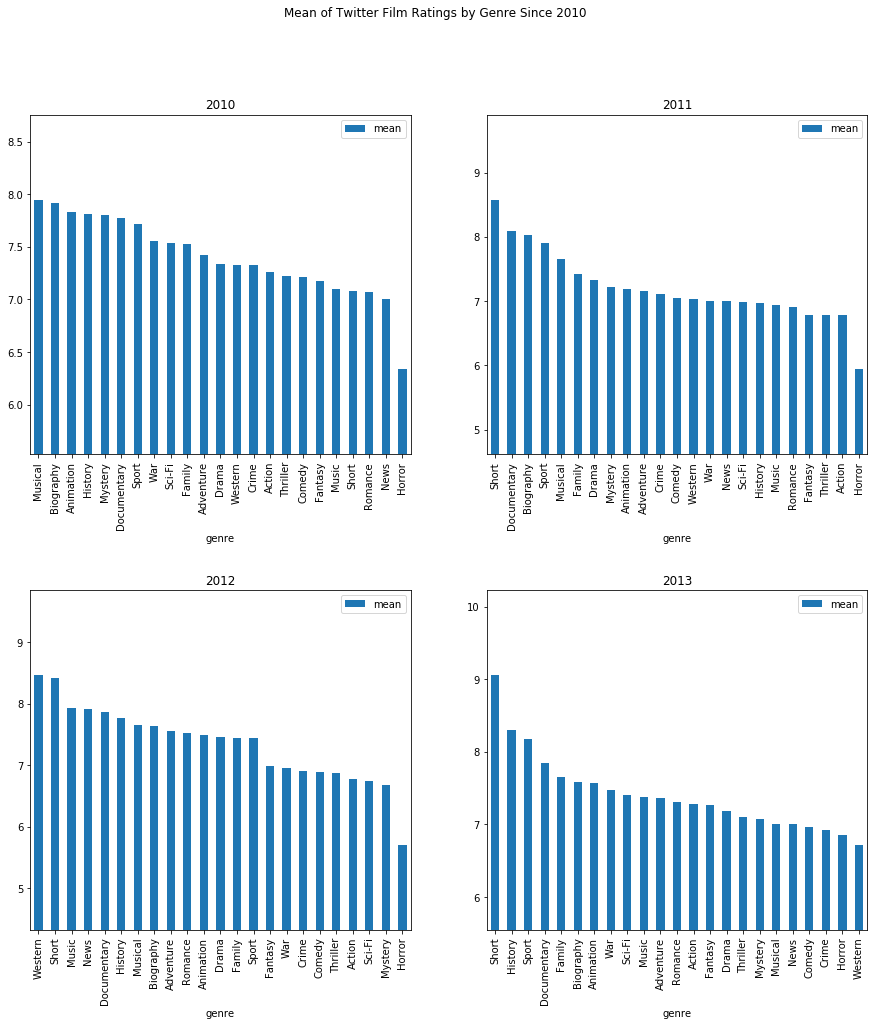

In [78]:
def plot_results(df, on):
    COLS  = 2
    years = df.year.unique()

    fig, axes = plt.subplots(nrows=int(np.ceil(len(years) / COLS)), ncols=COLS)
    fig.suptitle('{0} of Twitter Film Ratings by Genre Since {1}'.format(on.title(), int(years.min())))
    plt.subplots_adjust(hspace=0.4)

    for i, year in enumerate(years):
        target = df[df.year == year]
        (
            target
                .sort_values(by=on, ascending=False)
                .plot.bar(
                    ax=axes[i // COLS][i % COLS], x='genre', y=on,
                    figsize=(15, 15)
                ).set_title(int(year))
        )
        
        # Setting the start of the y-axis to better see the differences in scores
        # Adapted from https://stackoverflow.com/a/11217803/5491375
        axes[i // COLS][i % COLS].set_ylim([
            max(target[on].min() - 0.5 * (target[on].max() - target[on].min()), 0),
            (target[on].max() + 0.5 * (target[on].max() - target[on].min()))
        ])
        
plot_results(rankings, 'mean')

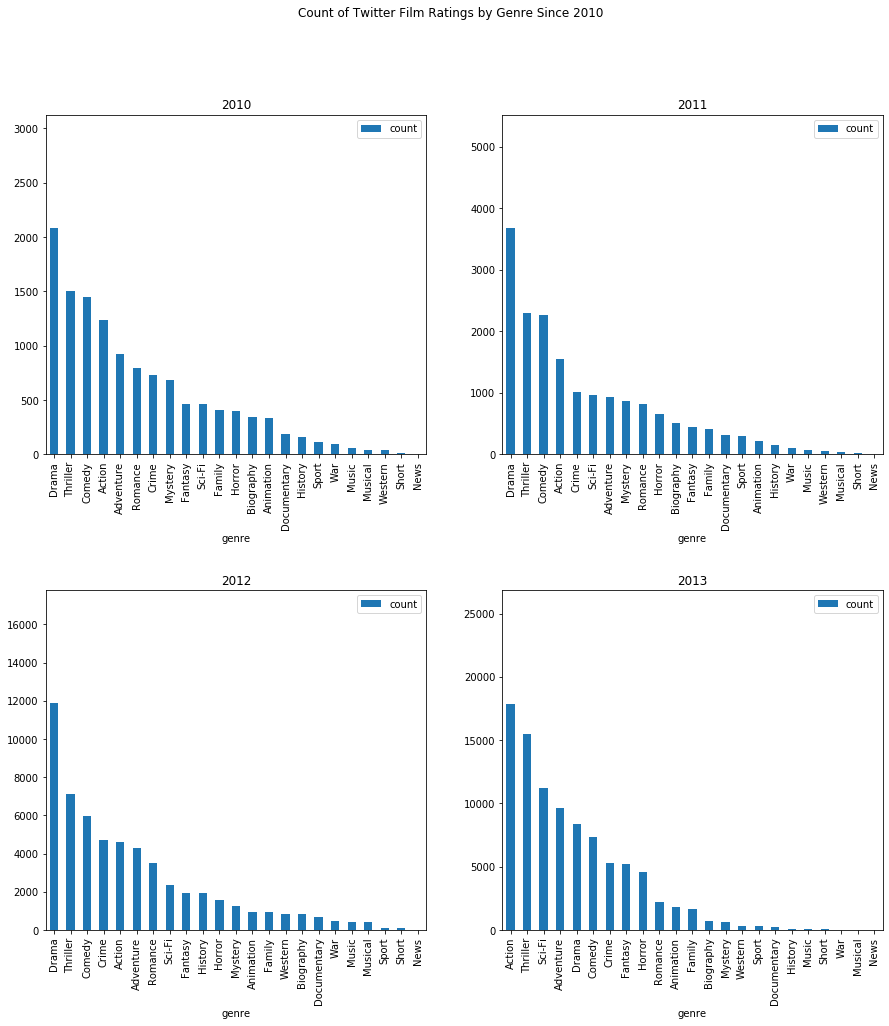

In [79]:
plot_results(rankings, 'count')

## Baysian Mean

The above shows only a simplistic view of the data and doesn't take into consideration the difference in the count of ratings per film.

An example of this is the drama genre in 2010. It has the most number of reviews by a considerable margin yet comes in at about the midway point in our rankings. This begs the question: what if we could normalise the average rating by taking into consideration the number of reviews it has recieved?

This is where a baysian mean comes into play and is the exact tool to assist with this problem.

Reference: http://www.ebc.cat/2015/01/05/how-to-rank-restaurants/

In [80]:
yearly_gb = df.groupby('year').agg({'rating': ['mean', 'count']})
yearly_gb.columns = yearly_gb.columns.droplevel()
yearly = yearly_gb.to_dict()

genres = df.groupby('year').genre.nunique()

rankings['weight'] = (
    rankings['count'] / 
    (rankings['count'] + rankings.year.map(yearly['count']))
)
rankings['baysian_mean'] = (
    rankings.weight * rankings['mean'] +
    (1 - rankings.weight) * rankings.year.map(yearly['mean'])
)

rankings

,year,genre,mean,count,weight,baysian_mean
0,2010.0,Action,7.265158,1237,0.089826,7.331566
1,2010.0,Adventure,7.418024,921,0.068450,7.343590
2,2010.0,Animation,7.828313,332,0.025804,7.350769
3,2010.0,Biography,7.919075,346,0.026863,7.353727
4,2010.0,Comedy,7.213499,1452,0.103818,7.325182
...,...,...,...,...,...,...
87,2013.0,Short,9.054795,73,0.000783,7.218883
88,2013.0,Sport,8.180212,283,0.003028,7.220360
89,2013.0,Thriller,7.101545,15471,0.142413,7.200939
90,2013.0,War,7.473684,19,0.000204,7.217497


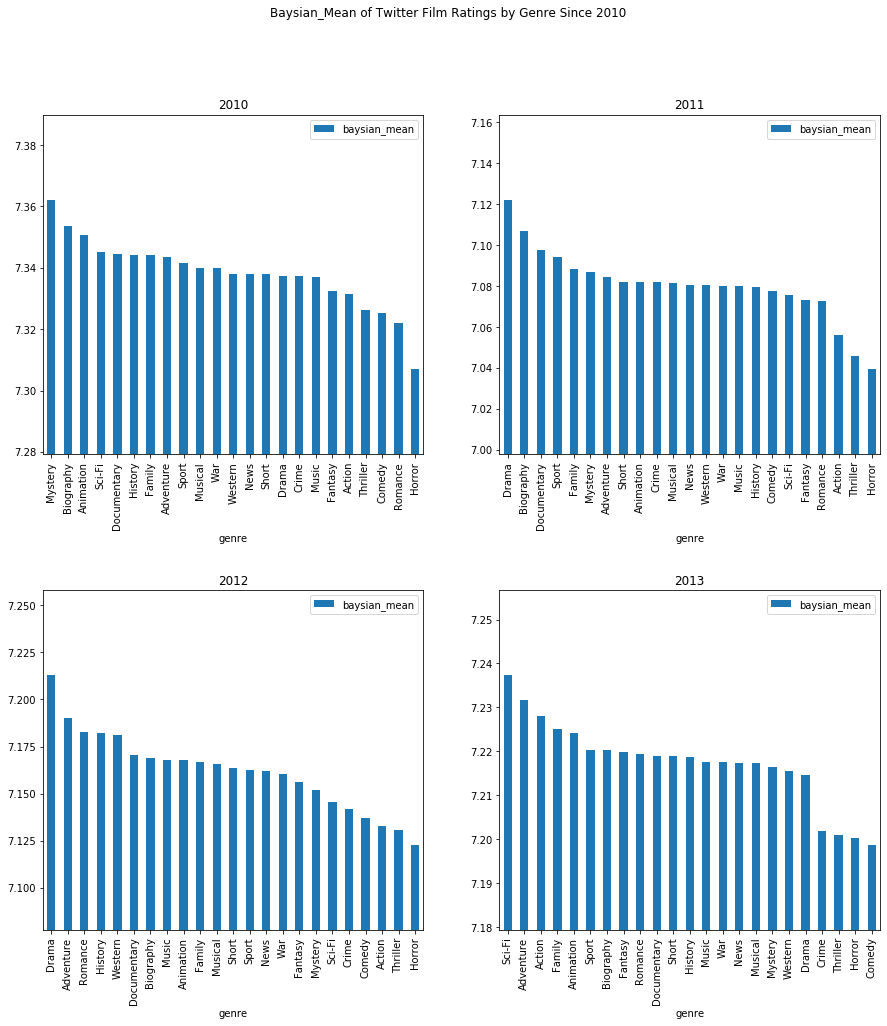

In [81]:
plot_results(rankings, 'baysian_mean')

# Conclusion

Ultimately, the term "popular" can be quite vague. In this context, we would commonly think about it as "the genre with the best averagr rating" which is a fair interpretation. However, there is always another way we can interpret our data. In this case we could interpret it to mean how many reviews it received (i.e. the count) or even a combination of the two aforementioned methods (i.e. the baysian mean). In each case it is likely that our mileage may vary depending on what metric we are going by.